In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries**

In [ ]:
import re
import os
import csv
import glob
import shutil
import imageio
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import imgaug as ia
ia.seed(1)
import xml.etree.ElementTree as ET
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
%matplotlib inline

In [ ]:
%cd /content/drive/MyDrive/01DataManagement/ProcessedData

/content/drive/MyDrive/01DataManagement/ProcessedData


Load images as Numpy arrays and append them to an images list. Here we are going to use our train set images for this process.

In [ ]:
images = []
for index, file in enumerate(glob.glob('/content/drive/MyDrive/01DataManagement/ProcessedData/train/*.jpg')):
    images.append(imageio.imread(file))
    
print('We have {} images'.format(len(images)))

We have 4156 images


Viewing some image samples using their indexes.


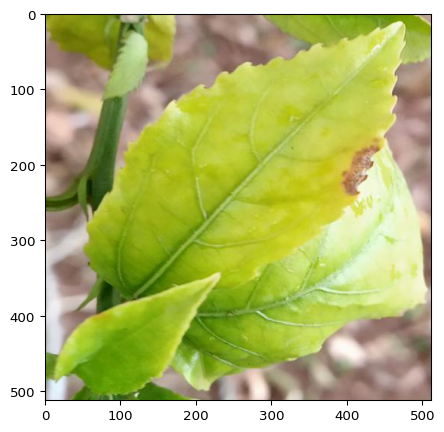

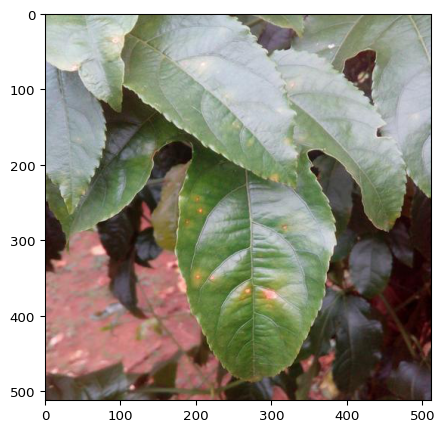

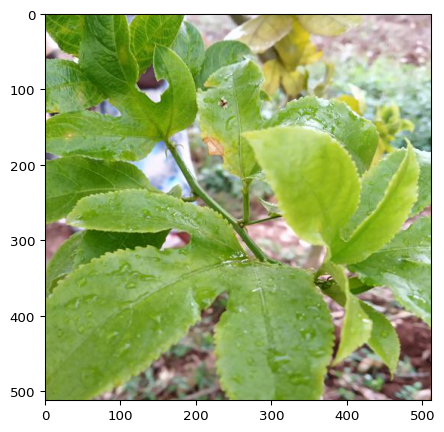

In [ ]:
ia.imshow(images[0])
ia.imshow(images[100])
ia.imshow(images[200])

Reading the train set csv file containing the labelled data details.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/01DataManagement/ProcessedData/annotations/train_labels.csv')

In [ ]:
df

,file_name,class_name,image_width,image_height,xmin,ymin,xmax,ymax
0,IMG_20200226_162115.jpg,brownspot,512,512,360,346,388,365
1,IMG_20200226_162115.jpg,brownspot,512,512,411,350,427,375
2,IMG_20200226_162115.jpg,brownspot,512,512,413,379,438,391
3,IMG_20200226_162115.jpg,brownspot,512,512,459,343,473,352
4,IMG_20200226_162115.jpg,brownspot,512,512,451,359,470,372
...,...,...,...,...,...,...,...,...
13110,IMG_20200226_101937.jpg,brownspot,512,512,297,427,350,460
13111,IMG_20200226_100603.jpg,brownspot,512,512,3,29,27,59
13112,IMG_20200226_100603.jpg,brownspot,512,512,109,267,152,311
13113,IMG_20200226_100603.jpg,brownspot,512,512,197,391,263,439


**Resizing:**


<b><u>*Choose any size you want to reduce or increase the images to*</u></b>

To resize the images we create two augmenters. One is used when the image height is more than 600px and the other when the width is more than 600px

**<i>Since efficient net cannot train big size images, we are changing the size of images to 400x400</i>**

In [ ]:

height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 600, "width": 'keep-aspect-ratio'})
])

width_resize = iaa.Sequential([ 
    iaa.Resize({"height": 'keep-aspect-ratio', "width": 600})
])

Function to Convert Bounding boxes on image object into array

In [ ]:
def bbs_obj_to_df(bbs_object):
    #convert bounding boxes on image object into array
    bbs_array = bbs_object.to_xyxy_array()
    
    #convert array into a dataframe ['xmin','ymin','xmax','ymax']
    df_bbs = pd.DataFrame(bbs_array, columns = ['xmin','ymin','xmax','ymax'])
    return df_bbs

**Resize_imgaug() function**

It will take pandas DataFrame with ['filename', 'image_width', 'image_height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] columns.

And apply resizing augmentation to the image and all corresponding bounding boxes. 

The function will return DataFrame with updated images and bounding boxes annotations. resize_imgaug() function takes the following variables:

- `df`: pandas DataFrame with ['filename', 'image_width', 'image_height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'] columns, labels_df in our case
    
- `images_path`: path to the folder with original images, 'images/' in our case(don't forget the forward slash)
    
- `aug_images_path`: path to the folder where augmented images will be stored, e.g. 'aug_images/' (the folder should be created in advance)
    
- `imageprefix`: prefix for augmented image filenames, e.g 'aug'




In [ ]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns = ['file_name','image_width','image_height','class_name', 'xmin', 'ymin', 'xmax', 'ymax'])
    grouped = df.groupby('file_name')    
    
    for filename in df['file_name'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   The only difference between if and elif statements below is the use of height_resize and width_resize augmentors
    #   deffined previously.

    #   If image height is greater than or equal to image width 
    #   AND greater than 512 px perform resizing augmentation shrinking image height to 512 px.
        if group_df['image_height'].unique()[0] >= group_df['image_width'].unique()[0] and group_df['image_height'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['file_name', 'image_width', 'image_height', 'class_name'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'image_width'] = image_aug.shape[1]
                info_df.at[index, 'image_height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['file_name'] = info_df['file_name'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    #   if image width is greater than image height 
    #   AND greater than 600px perform resizing augmentation shrinking image width to 600px
        elif group_df['image_width'].unique()[0] > group_df['image_height'].unique()[0] and group_df['image_width'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['file_name', 'image_width', 'image_height', 'class_name'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'image_width'] = image_aug.shape[1]
                info_df.at[index, 'image_height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['file_name'] = info_df['file_name'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 512px 
        else:
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

Apply `resizing augmentation` to the images and writing the updated images and bounding boxes annotations to the DataFrame.

In [ ]:
resized_images = resize_imgaug()

In [ ]:
#View the new dataframe.
resized_images_df

**Augmeting images to upsample the dataset.**

Setting up the Augmentation parameters:

In [ ]:
aug_a = iaa.SomeOf(2, [
    iaa.Affine(scale = (0.5, 1.5)),
    iaa.Affine(rotate = (-60, 60)),
    iaa.Affine(translate_percent = {"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.Fliplr(0.2),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma = (1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale = (0.03*255, 0.05*255))
])

In [ ]:
aug_b = iaa.Sequential([
      iaa.Fliplr(0.9) ,                         # horizontally flip 90% of the images
      iaa.GaussianBlur(sigma = (0, 2.0))        # blur images with a sigma of 0 to 1.0
])

In [ ]:
aug_c = iaa.Sequential([
    
    iaa.Flipud(1)                             # Flip vertically all images

                        
])

**Image_aug() function**

It takes the same variables as resize_imgaug(), plus: ` -augmenter`: augmentation parameters of imgaug library.
We can now apply custom augmenters. image_aug() function is very similar to resize_imgaug().

But there's a caveat.

- Augmentations, like zooming in and translating the image in x/y directions, can lead to objects of interest (e'g', red pandas) partially or completely move out of image pane. 
- image_aug( ) function will clip the bounding box if the object of interest is partially outside of image pane. And it will ignore image altogether if no bounding boxes left in image pane.

In [ ]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns= ['file_name','image_width','image_height','class_name', 'xmin', 'ymin', 'xmax', 'ymax'])
    grouped = df.groupby('file_name')
    
    for filename in df['file_name'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['file_name', 'image_width', 'image_height', 'class_name'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'image_width'] = image_aug.shape[1]
                info_df.at[index, 'image_height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['file_name'] = info_df['file_name'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

Apply augmentation to our images and save files into 'aug_images/'  folder  with 'aug1_' prefix.

Then write the updated images and bounding boxes information to the augmented_images_df dataframe.

In [ ]:
%mkdir /content/drive/MyDrive/01DataManagement/ProcessedData/aug_images1
%mkdir /content/drive/MyDrive/01DataManagement/ProcessedData/aug_images2
%mkdir /content/drive/MyDrive/01DataManagement/ProcessedData/aug_images3


In [ ]:
images_dir = '/content/drive/MyDrive/01DataManagement/ProcessedData/train/'
aug_images_dir1 = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images1/'
aug_images_dir2 = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images2/'
aug_images_dir3 = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images3/'

In [ ]:
%%capture

augmented_images_df1 = image_aug(df, images_dir, aug_images_dir1, 'aug1_', aug_a)

In [ ]:
%%capture
augmented_images_df2 = image_aug(df, images_dir, aug_images_dir2, 'aug2_', aug_b)

In [ ]:
%%capture
augmented_images_df3 = image_aug(df, images_dir, aug_images_dir3, 'aug3_', aug_c)

In [ ]:
#View the new dataframe
augmented_images_df1

,file_name,image_width,image_height,class_name,xmin,ymin,xmax,ymax
0,aug1_IMG_20200226_162115.jpg,512,512,brownspot,459.465576,434.315094,487.563263,453.459320
1,aug1_IMG_20200226_162115.jpg,512,512,brownspot,510.485565,438.113800,512.000000,463.196014
2,aug1_IMG_20200226_162115.jpg,512,512,brownspot,494.542511,449.216858,506.599121,460.278625
3,aug1_IMG_20200226_162115.jpg,512,512,brownspot,273.401001,422.311157,294.514221,444.419220
4,aug1_IMG_20200226_162115.jpg,512,512,brownspot,269.612610,463.362213,284.679474,476.439423
...,...,...,...,...,...,...,...,...
13017,aug1_IMG_20200226_101937.jpg,512,512,brownspot,98.640617,451.319580,178.362839,512.000000
13018,aug1_IMG_20200226_100603.jpg,512,512,brownspot,48.275471,220.000183,118.607719,291.273773
13019,aug1_IMG_20200226_100603.jpg,512,512,brownspot,117.388374,409.475800,218.636810,493.779877
13020,aug1_IMG_20200226_100603.jpg,512,512,brownspot,471.187439,186.278061,512.000000,280.065277


In [ ]:
augmented_images_df2

,file_name,image_width,image_height,class_name,xmin,ymin,xmax,ymax
0,aug2_IMG_20200226_162115.jpg,512,512,brownspot,123.0,346.0,151.0,365.0
1,aug2_IMG_20200226_162115.jpg,512,512,brownspot,84.0,350.0,100.0,375.0
2,aug2_IMG_20200226_162115.jpg,512,512,brownspot,73.0,379.0,98.0,391.0
3,aug2_IMG_20200226_162115.jpg,512,512,brownspot,38.0,343.0,52.0,352.0
4,aug2_IMG_20200226_162115.jpg,512,512,brownspot,41.0,359.0,60.0,372.0
...,...,...,...,...,...,...,...,...
13110,aug2_IMG_20200226_101937.jpg,512,512,brownspot,161.0,427.0,214.0,460.0
13111,aug2_IMG_20200226_100603.jpg,512,512,brownspot,484.0,29.0,508.0,59.0
13112,aug2_IMG_20200226_100603.jpg,512,512,brownspot,359.0,267.0,402.0,311.0
13113,aug2_IMG_20200226_100603.jpg,512,512,brownspot,248.0,391.0,314.0,439.0


In [ ]:
augmented_images_df3

,file_name,image_width,image_height,class_name,xmin,ymin,xmax,ymax
0,aug3_IMG_20200226_162115.jpg,512,512,brownspot,360.0,146.0,388.0,165.0
1,aug3_IMG_20200226_162115.jpg,512,512,brownspot,411.0,136.0,427.0,161.0
2,aug3_IMG_20200226_162115.jpg,512,512,brownspot,413.0,120.0,438.0,132.0
3,aug3_IMG_20200226_162115.jpg,512,512,brownspot,459.0,159.0,473.0,168.0
4,aug3_IMG_20200226_162115.jpg,512,512,brownspot,451.0,139.0,470.0,152.0
...,...,...,...,...,...,...,...,...
13110,aug3_IMG_20200226_101937.jpg,512,512,brownspot,297.0,51.0,350.0,84.0
13111,aug3_IMG_20200226_100603.jpg,512,512,brownspot,3.0,452.0,27.0,482.0
13112,aug3_IMG_20200226_100603.jpg,512,512,brownspot,109.0,200.0,152.0,244.0
13113,aug3_IMG_20200226_100603.jpg,512,512,brownspot,197.0,72.0,263.0,120.0


Techniques for comparing original resized images and augmented copies. Bounding boxes are drawn to ensure that the augmentation process was correct.

In [ ]:
#DON'T RUN CELL WITH LIMITED RAM RESOURCE. & may not run because some images with no bounding boxes were deleted. Account for that later

grouped_resized = resized_images_df.groupby('file_name')   # CHANGE THIS ACCORDING TO YOUR DataFrame
grouped_augmented = augmented_images_df.groupby('file_name') # CHANGE THIS ACCORDING TO YOUR DataFrame

for filename in resized_images_df['file_name'].unique():    
    
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['file_name', 'image_width', 'image_height', 'class_name'], axis=1).values
    resized_img = imageio.imread('images/'+filename)
    bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    
    group_a_df = grouped_augmented.get_group('aug1_'+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['file_name', 'image_width', 'image_height', 'class_name'], axis=1).values
    augmented_img = imageio.imread('aug_images/'+'aug1_'+filename)
    bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    
    ia.imshow(np.hstack([
            bbs_r.draw_on_image(resized_img, size=2),
            bbs_a.draw_on_image(augmented_img, size=2)
            ]))

**Combining our two newly obtained dataframes into a csv file**

1. ` resized_images_df` ----> original resized images annotations
2. `augmented_images_df` ----> augmented images annotations

We are going to concat the two dataframes together and save all new labels into the all_labels.csv file. 


In [ ]:
all_labels_df = pd.concat([df, augmented_images_df1,augmented_images_df2,augmented_images_df3])
all_labels_df.to_csv('/content/drive/MyDrive/01DataManagement/ProcessedData/all_train_labels.csv', index=False)

In [ ]:
#lastly copy all the augmented images into the same folder as original resized images.

for file in os.listdir('aug_images'):
    shutil.copy('aug_images/'+file, 'images/'+file)

**NB:** Copying files usually takes very long on google colab. Therefore, we are just going to move the files using a python script. In order to obtain efficiency.

In [ ]:
%mkdir /content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles 

In [ ]:
source = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images1'
destination = '/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles'
files = os.listdir(source)
for file in files:
  new_path = shutil.move(f"{source}/{file}", destination)
  print(new_path)

/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_162115.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_102741.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_160239.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_123033.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_161603.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_161144_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_094334.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_103309_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_160155.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug1_IMG_20200226_161538.jpg
/content/drive/MyDrive/01D

In [ ]:
source = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images2'
destination = '/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles'
files = os.listdir(source)
for file in files:
  new_path = shutil.move(f"{source}/{file}", destination)
  print(new_path)

/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_162115.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_102741.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_160239.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_123033.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_161603.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_161144_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_094334.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_103309_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_160155.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug2_IMG_20200226_161538.jpg
/content/drive/MyDrive/01D

In [ ]:
source = '/content/drive/MyDrive/01DataManagement/ProcessedData/aug_images3'
destination = '/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles'
files = os.listdir(source)
for file in files:
  new_path = shutil.move(f"{source}/{file}", destination)
  print(new_path)

/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_162115.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_102741.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_160239.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_123033.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_161603.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_161144_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_094334.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_103309_1.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_160155.jpg
/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles/aug3_IMG_20200226_161538.jpg
/content/drive/MyDrive/01D

Total number of new available training files for the EfficientDet models:

In [ ]:
%cd /content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles 
!ls -1 | wc -l


/content/drive/MyDrive/01DataManagement/ProcessedData/alltrainfiles
12415


Viewing the new training set dataframe.

In [ ]:
traindata_df = pd.read_csv('/content/drive/MyDrive/01DataManagement/ProcessedData/all_train_labels.csv')
traindata_df

,file_name,class_name,image_width,image_height,xmin,ymin,xmax,ymax
0,IMG_20200226_162115.jpg,brownspot,512,512,360.0,346.0,388.0,365.0
1,IMG_20200226_162115.jpg,brownspot,512,512,411.0,350.0,427.0,375.0
2,IMG_20200226_162115.jpg,brownspot,512,512,413.0,379.0,438.0,391.0
3,IMG_20200226_162115.jpg,brownspot,512,512,459.0,343.0,473.0,352.0
4,IMG_20200226_162115.jpg,brownspot,512,512,451.0,359.0,470.0,372.0
...,...,...,...,...,...,...,...,...
52362,aug3_IMG_20200226_101937.jpg,brownspot,512,512,297.0,51.0,350.0,84.0
52363,aug3_IMG_20200226_100603.jpg,brownspot,512,512,3.0,452.0,27.0,482.0
52364,aug3_IMG_20200226_100603.jpg,brownspot,512,512,109.0,200.0,152.0,244.0
52365,aug3_IMG_20200226_100603.jpg,brownspot,512,512,197.0,72.0,263.0,120.0
